# Quality Assessment
Now it's your turn. Follow [the steps on the platform](https://learn.wbscodingschool.com/courses/data-science/lessons/%f0%9f%93%9d-5-data-quality/) and use what you've learnt to see how reliable the data is.

In [ ]:
import pandas as pd

Load our cleaned DataFrames

In [ ]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

In [ ]:
orders_df = orders_cl.copy()

In [ ]:
orderlines_df = orderlines_cl.copy()

In [ ]:
products_df = products_cl.copy()

## 1.&nbsp; Define Pandas display format

In [ ]:
# your code here
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)

## 2.&nbsp; Exclude unwanted orders

In [ ]:
# Another idea:
# Inner merge
# Order ids
# filter each separate table to those ids

In [ ]:
# your code here
# 1. Filter down to just sales
state_mask = orders_df['state'].isin(['Cancelled', 'Shopping Basket'])
orders_completed = orders_df.loc[~state_mask].copy()

# 2. Filter orderlines just those in the orders data frame
# 2.1 identify orders in orders df
orders_in_o_df = orders_completed['order_id']
# 2.2 filter orderlines to just those
orderlines_connected = orderlines_df.loc[orderlines_df['id_order'].isin(orders_in_o_df)].copy()

#3. Filter orders down to just those in the orderlines data frame
# 2.1 identify orders in orderlines df
orders_in_ol_df = orderlines_df['id_order']
# 2.2 filter orders to just those
orders_connected = orders_completed.loc[orders_completed['order_id'].isin(orders_in_ol_df)]

In [ ]:
# Are there any orderlines with orders not in the orders data frame
set(orderlines_df['id_order']) - set(orders_df['order_id'])

In [ ]:
# Are there any orders with orders not in the orderlines data frame
set(orders_connected['order_id']) - set(orderlines_connected['id_order'])

set()

In [ ]:
assert set(orders_connected['order_id']) ^ set(orderlines_connected['id_order']) == set([])

set()

## 3.&nbsp; Exclude orders with unknown products


In [ ]:
# Order ID 19
    # - iPhone
    # - Case      (normal price missing)
    # - Charger

In [ ]:
# Clean Everything, then Analyze

# Clean for Each Calculation

In [ ]:
# your code here
# 1. Identify corrupted orderlines
existing_products = products_cl['sku']
corrupted_filter = ~(orderlines_connected['sku'].isin(existing_products))

# 2. Identify orders with corrupted orderlines (they are corrupted)
corrupted_orders = orderlines_connected.loc[corrupted_filter, 'id_order']
clean_orders = orders_connected.loc[~(orders_connected['order_id'].isin(corrupted_orders))]

# 3. Identify other orderlines in corrupted orders
clean_orderlines = orderlines_connected.loc[~(orderlines_connected['id_order'].isin(corrupted_orders))]

## 4.&nbsp; Explore the revenue from different tables

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
# your code here
clean_orderlines.loc[:, 'unit_price_total'] = (clean_orderlines['unit_price']
                                               * clean_orderlines['product_quantity'])

#### Step 2:
Group by `id_order`, summarising by the sum of `unit_price_total`

In [ ]:
clean_orders

,order_id,created_date,total_paid,state
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
5,245275,2017-06-28 11:35:37,149.00,Completed
6,245595,2017-01-21 12:52:47,112.97,Completed
...,...,...,...,...
226894,527392,2018-03-14 13:55:11,34.99,Pending
226896,527394,2018-03-14 13:55:15,161.00,Place Order
226898,527396,2018-03-14 13:55:44,141.58,Place Order
226899,527397,2018-03-14 13:56:38,42.99,Place Order


In [ ]:
# your code here
price_totals = (
    clean_orderlines
    .groupby('id_order')
    .agg({'unit_price_total':'sum'})
)
orders_info = clean_orders.merge(price_totals,
                                 left_on='order_id',
                                 right_on='id_order')
orders_info

### What is the average difference between `total_paid` and `unit_price_total`?

orders - orders_info <br>
orderlines -clean_orderlines <br>
products - products_cl

In [ ]:
# your code here
orders_info.loc[:, 'difference'] = (orders_info['total_paid']
                                    - orders_info['unit_price_total'])
orders_info['difference'].describe()

,difference
count,77195.00
mean,3.37
std,19.35
min,-165.00
25%,0.00
50%,3.99
75%,4.99
max,3984.99


### What is the distribution of these differences?

In [ ]:
q1 = orders_info['difference'].quantile(0.25)
q3 = orders_info['difference'].quantile(0.75)

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)
lower_bound = q1 - (1.5 * iqr)
print(upper_bound, lower_bound)

12.475000000000023 -7.485000000000014


<Axes: >

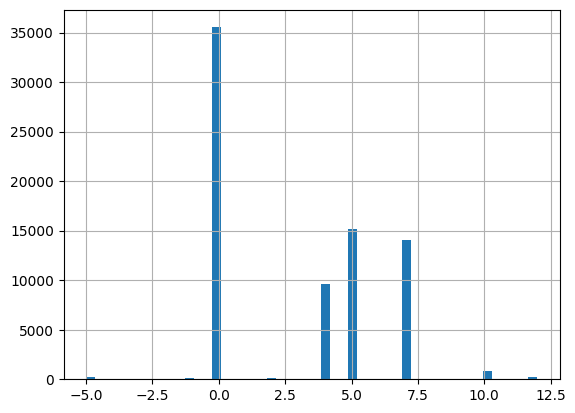

In [ ]:
# your code here
(
    orders_info
    .loc[orders_info['difference'].between(lower_bound, upper_bound)]
    ['difference'].hist(bins=50)
)

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

In [ ]:
# your explanation here

### If there are differences that you can’t explain: what should you do with these orders?

In [ ]:
# your code here

## 5.&nbsp; Become confident about your dataset

Let's hear your thoughts about what you discovered.

In [ ]:
# your thoughts & code here

Do not forget to download your quality controlled DataFrames

In [ ]:
from google.colab import files

orders_quality_controlled.to_csv("orders_qu.csv", index=False)
files.download("orders_qu.csv")

orderlines_quality_controlled.to_csv("orderlines_qu.csv", index=False)
files.download("orderlines_qu.csv")